In [222]:
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import scipy
import scipy.io
import matplotlib.pyplot as plt
import random
import pickle
from torch.utils.data import Dataset, DataLoader
import scipy.signal as sig
from scipy.stats import pearsonr
from utils import *
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace

In [223]:
device = torch.device(0)
device

device(type='cuda', index=0)

In [224]:
raw = scipy.io.loadmat('./datasets/raw_training_data.mat')
data_glove_1 = raw['train_dg'][0][0]
data_glove_1 = np.delete(data_glove_1, 3, 1)
data_glove_2 = raw['train_dg'][1][0]
data_glove_2 = np.delete(data_glove_2, 3, 1)
data_glove_3 = raw['train_dg'][2][0]
data_glove_3 = np.delete(data_glove_3, 3, 1)

ecog_1 = raw['train_ecog'][0][0]
ecog_2 = raw['train_ecog'][1][0]
ecog_3 = raw['train_ecog'][2][0]

labels_1 = np.argmax(data_glove_1, axis=1)
labels_2 = np.argmax(data_glove_2, axis=1)
labels_3 = np.argmax(data_glove_3, axis=1)

In [225]:
ecog_1 = filter_data(ecog_1)
ecog_2 = filter_data(ecog_2)
ecog_3 = filter_data(ecog_3)

train_test_ratio = 0.7

ecog_1_train = ecog_1[:int(train_test_ratio * ecog_1.shape[0])]
ecog_1_test = ecog_1[int(train_test_ratio * ecog_1.shape[0]):]
data_glove_1_train = data_glove_1[:int(train_test_ratio * data_glove_1.shape[0])]
data_glove_1_test = data_glove_1[int(train_test_ratio * data_glove_1.shape[0]):]

ecog_2_train = ecog_2[:int(train_test_ratio * ecog_2.shape[0])]
ecog_2_test = ecog_2[int(train_test_ratio * ecog_2.shape[0]):]
data_glove_2_train = data_glove_2[:int(train_test_ratio * data_glove_2.shape[0])]
data_glove_2_test = data_glove_2[int(train_test_ratio * data_glove_2.shape[0]):]

ecog_3_train = ecog_3[:int(train_test_ratio * ecog_3.shape[0])]
ecog_3_test = ecog_3[int(train_test_ratio * ecog_3.shape[0]):]
data_glove_3_train = data_glove_3[:int(train_test_ratio * data_glove_3.shape[0])]
data_glove_3_test = data_glove_3[int(train_test_ratio * data_glove_3.shape[0]):]

In [ ]:
data_ecog_train = ecog

In [270]:
class FingerECOGDataset(Dataset):
    def __init__(self, ecog, dg, window=2000, overlap=500):
        self.ecog = np.float32(ecog.reshape(-1, 1, window,ecog.shape[1]))
        self.ecog = (self.ecog - self.ecog.mean()) / self.ecog.std()
        self.ecog = np.float32(self._concatenate(self.ecog, overlap))
#         self.ecog = np.transpose(self.ecog, (0,1,3,2))
        self.dg = np.float32(dg.reshape(-1, window, 4).mean(axis=1))
        
    def _concatenate(self, feats, overlap):
        if overlap == 0:
            return feats
        new_features = np.zeros((feats.shape[0], feats.shape[1], feats.shape[2] + 2 * overlap, feats.shape[3]))
        for i in range(0, feats.shape[0]):
            if i > 0:
                new_features[i, 0, 0: overlap] = feats[i - 1, 0, -overlap:]
            new_features[i, 0, overlap: overlap + feats.shape[2]] = feats[i, 0]
            if i < feats.shape[0] - 1:
                new_features[i, 0, overlap + feats.shape[2]:] = feats[i + 1, 0, :overlap]
        return new_features

    def __len__(self):
        return len(self.ecog)

    def __getitem__(self, idx):
        
        return self.ecog[idx], self.dg[idx]

In [354]:
window=200
overlap=40

dataset_s1_train = FingerECOGDataset(ecog_1_train.copy(), data_glove_1_train.copy(), window=window, overlap=overlap)
dataset_s1_valid = FingerECOGDataset(ecog_1_test.copy(), data_glove_1_test.copy(), window=window, overlap=overlap)

train_loader = DataLoader(dataset_s1_train, batch_size=16, shuffle=False)
test_loader = DataLoader(dataset_s1_valid, batch_size=16, shuffle=False)

In [355]:
dataset_s1_train[0][0].shape

(1, 280, 62)

In [356]:
from torch import nn
class FingerFlexionCNN(nn.Module):
    def __init__(self, num_fingers) -> None:
        super(FingerFlexionCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, (1, 4))
        self.pool1 = nn.MaxPool2d((1, 4), stride=(1, 4))
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(0.15)
        
        self.conv2 = nn.Conv2d(16, 32, (16, 2))
        self.pool2 = nn.MaxPool2d((16, 2), stride=(4, 2))
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(0.25)
        
        self.conv3 = nn.Conv2d(32, 64, (8, 2))
        self.pool3 = nn.MaxPool2d((8, 2), stride=(4, 2))
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(0.25)
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4992, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_fingers)
        
        self.relu = nn.ReLU()
        
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = self.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = self.relu(self.conv3(x))
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        output = self.fc3(x)
        
        return output
    

In [357]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, (1,62), padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(16, False)
        
        # Layer 2
        self.padding1 = nn.ZeroPad2d((16, 17, 0, 1))
        self.conv2 = nn.Conv2d(1, 4, (2, 64))
        self.batchnorm2 = nn.BatchNorm2d(4, False)
        self.pooling2 = nn.MaxPool2d(2, 4)
        
        # Layer 3
        self.padding2 = nn.ZeroPad2d((2, 1, 4, 3))
        self.conv3 = nn.Conv2d(4, 8, (8, 4))
        self.batchnorm3 = nn.BatchNorm2d(8, False)
        self.pooling3 = nn.MaxPool2d((2, 4))
        
        # FC Layer
        # NOTE: This dimension will depend on the number of timestamps per sample in your data.
        # I have 120 timepoints. 
        #4, 2, 487
        self.fc1 = nn.Linear(960, 256)
        self.fc2 = nn.Linear(256, 4)
        

    def forward(self, x):
        # Layer 1
      #  x = x.double()
        x = F.elu(self.conv1(x))
        x = self.batchnorm1(x)
        x = F.dropout(x, 0.75)
        x = x.permute(0, 3, 1, 2)
        
        # Layer 2
        
        x = self.padding1(x)
        x = F.elu(self.conv2(x))
        x = self.batchnorm2(x)
        x = F.dropout(x, 0.75)
        x = self.pooling2(x)
        
        # Layer 3
#         print(x.size())
        x = self.padding2(x)
        x = F.elu(self.conv3(x))
        x = self.batchnorm3(x)
        x = F.dropout(x, 0.25)
        x = self.pooling3(x)
        # print (x.size())
        # FC Layer
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [358]:
net = EEGNet().to(device)
# net = EEGNetRegressor(4).to(device)
# net = EEGNet(n_classes=4, channels=62, samples=3000).to(device) #.cuda(0)
# net = FingerFlexionCNN(4).to(device)
#print (net.forward(Variable(torch.Tensor(np.random.rand(1, 1, 120, 64)))))#.cuda(0))))
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=0.01)

net.train()
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    correct = 0
    total = 0
    pred = []
    for (i, (ecog, dg)) in enumerate(train_loader):
        # print(ecog.shape)
        ecog = ecog.to(device)
        dg = dg.to(device)
        output = net(ecog)
        pred += [output.detach().cpu().numpy()]
        loss = criterion(output, dg)
        # print (loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    pred = np.concatenate(pred)
    train_cor = correlation_dl(np.repeat(pred, window, axis=0), data_glove_1_train)[1]
    train_loss = running_loss / len(train_loader)
    # train_acc = correct / total

    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        pred = []
        for (i, (ecog, dg)) in enumerate(test_loader):
            ecog = ecog.to(device)
            dg = dg.to(device)
            output = net(ecog).to(device)
            pred += [output.detach().cpu().numpy()]
            loss = criterion(output, dg)
            running_loss += loss.item()

        pred = np.concatenate(pred)
        val_cor = correlation_dl(np.repeat(pred, window, axis=0), data_glove_1_test)[1]
        
        valid_loss = running_loss / len(test_loader)
    # print(f'Epoch {epoch + 1} | Train loss: {train_loss:.3f} | Train Acc: {train_acc:.3f} | Valid loss: {valid_loss:.3f} | Valid Acc: {val_cor}')
    print(f'Epoch {epoch + 1} | Train loss: {train_loss:.3f} | Train Cor: {train_cor:.3f} | Valid loss: {valid_loss:.3f} | Valid Cor: {val_cor}')
    # break

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x240 and 960x256)

In [359]:
correlation_dl(np.repeat(pred, 2000, axis=0), data_glove_1_test)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [383]:
class BiasLayer(nn.Module):
    def __init__(self, shape):
        super(BiasLayer, self).__init__()
        init_bias = torch.zeros(shape)
        self.bias = nn.Parameter(init_bias, requires_grad=True)
    
    def forward(self, x):
        return x + self.bias

class ConvAutoEncoder(nn.Module):
    def __init__(self, K, num_filters=32, filter_size=16):
        super(ConvAutoEncoder, self).__init__()

        # With padding=0, the number of pixels cut off from each image dimension
        # is filter_size // 2. Double it to get the amount of pixels lost in
        # width and height per Conv2D layer, or added back in per
        # ConvTranspose2D layer.
        filter_reduction = filter_size - 1

        # After passing input through two Conv2d layers, the shape will be
        # 'shape_after_conv'. This is also the shape that will go into the first
        # deconvolution layer in the decoder
        self.shape_after_conv = (
            num_filters,
            my_dataset_size[1] - 3 * filter_reduction,
            my_dataset_size[2] - 3 * filter_reduction,
        )
        flat_size_after_conv = (
            self.shape_after_conv[0]
            * self.shape_after_conv[1]
            * self.shape_after_conv[2]
        )
        ####################################################################
        # Fill in all missing code below (...),
        # then remove or comment the line below to test your class
        # raise NotImplementedError("Please complete the ConvAutoEncoder class!")
        ####################################################################
        # Your code here

        # Create encoder layers (BiasLayer, Conv2d, Conv2d, Flatten, Linear)
        self.encoder = nn.Sequential(BiasLayer(my_dataset_size),
                                      nn.Conv2d(my_dataset_size[0], num_filters, filter_size),
                                      nn.ReLU(),
                                      nn.Conv2d(num_filters, num_filters, filter_size),
                                      nn.ReLU(),
                                      nn.Conv2d(num_filters, num_filters, filter_size),
                                      nn.ReLU(),
                                      nn.Flatten(),
                                      nn.Linear(flat_size_after_conv, K))  
        # Create decoder layers (Linear, Unflatten(-1, self.shape_after_conv), ConvTranspose2d, ConvTranspose2d, BiasLayer)
        self.decoder = nn.Sequential(nn.Linear(K, flat_size_after_conv),
                                        nn.ReLU(),
                                        nn.Unflatten(1, self.shape_after_conv),
                                        nn.ConvTranspose2d(num_filters, num_filters, filter_size),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(num_filters, num_filters, filter_size),
                                        nn.ReLU(),
                                        nn.ConvTranspose2d(num_filters, my_dataset_size[0], filter_size),
                                        nn.ReLU(),
                                     BiasLayer(my_dataset_size))  

    def encode(self, x):
        h = self.encoder(x)  # Your code here: encode batch of images (don't forget ReLUs!)
        return h

    def decode(self, h):
        x_prime = self.decoder(h)  # Your code here: decode batch of h vectors (don't forget ReLUs!)
        return x_prime

    def forward(self, x):
        return self.decode(self.encode(x))

In [ ]:
my_dataset_size = dataset_s1_train[0][0].shape
def train_autoencoder(autoencoder, dataset, epochs=20, batch_size=16):
    autoencoder.to(device)
    optim = torch.optim.Adam(autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)
    loss_fn = nn.MSELoss()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,
                        pin_memory=True, num_workers=2)
    mse_loss = torch.zeros(epochs*(len(dataset)//batch_size + 1), device=device)
    i = 0
    for epoch in trange(epochs, desc='Epoch'):
        for im_batch, _ in loader:
            im_batch = im_batch.to(device)
            optim.zero_grad()
            ####################################################################
            # Fill in all missing code below (...),
            # then remove or comment the line below to test your function
            # raise NotImplementedError("Please complete the train_autoencoder function!")
            #################################################################### 
            loss = loss_fn(autoencoder(im_batch), im_batch) # your code here
            loss.backward()
            optim.step()

            mse_loss[i] = loss.detach()
            i += 1
    # After training completes, make sure the model is on CPU so we can easily
    # do more visualizations and demos.
    autoencoder.to('cpu')
    return mse_loss.cpu()

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

TypeError: iteration over a 0-d tensor

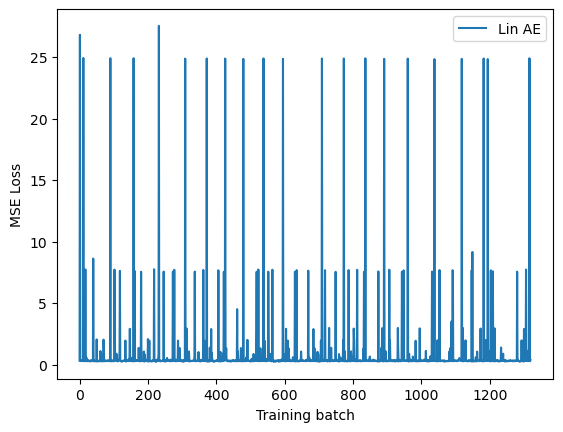

In [386]:
# from tqdm.notebook import tqdm, trange
conv_ae = ConvAutoEncoder(K=64)
conv_losses = train_autoencoder(conv_ae, dataset_s1_train)

 
plt.figure()
# plt.plot(lin_losses)
plt.plot(conv_losses)
plt.legend(['Lin AE', 'Conv AE'])
plt.xlabel('Training batch')
plt.ylabel('MSE Loss')
plt.ylim([0,2*max(torch.as_tensor(conv_losses).median())])
plt.show()

In [343]:
my_dataset_size

(1, 1000, 62)